# Dynamic U-Net based Semantic Segmentation for Building Extraction from Satellite and Aerial Imagery


## About
### Author: Chintan Bimal Maniyar (M.Tech, PRSD)
### Dated: Dec 21, 2020
### Execution Details: 
* OS - *Windows 10*
* Environment - *Python 3.6.4* in *conda*
* Framework - *fastai 1.0.61* wrapped on *Pytorch 1.5.0*  
* GPU Support - *Cuda 10.2* on *NVIDIA GeForce GTX 1050*

### Detials:
This notebook explores the semantic segmentation of buildings using a Dyanmic U-Net architecture.
The model is trained on 8716 tiles from the following four sources of data:
    1. [OpenAI Mapping Challenge](https://competitions.codalab.org/competitions/20100)
    2. [CrowdAI Mapping Challenge](https://registry.opendata.aws/spacenet/)
    3. [Massachuesets Building Dataset](https://www.kaggle.com/balraj98/massachusetts-buildings-dataset)
    4. [Inria Building Dataset](https://project.inria.fr/aerialimagelabeling/)

## 0. Configuring Environment

In [1]:
%matplotlib inline

In [2]:
# UNSAFE

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
from matplotlib import pyplot as plt

## 1. Importing Required Libraries
This experiment is performed using FastAI - it is a wrapper written on top of PyTorch, which has some unique and good functionalities such as learning rate finder and model fallback while training (and not after)

In [4]:
from fastai.vision import *

In [5]:
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.4
fastai        : 1.0.61
fastprogress  : 0.2.7
torch         : 1.5.0
torch cuda    : 10.2 / is available
torch cudnn   : 7604 / is enabled

=== Hardware === 
torch devices : 1
  - gpu0      : GeForce GTX 1050

=== Environment === 
platform      : Windows-10-10.0.19041-SP0
conda env     : base
python        : E:\Users\Chintan-Maniyar\Anaconda3\python.exe
sys.path      : E:\Users\Chintan-Maniyar\Anaconda3\python36.zip
E:\Users\Chintan-Maniyar\Anaconda3\DLLs
E:\Users\Chintan-Maniyar\Anaconda3\lib
E:\Users\Chintan-Maniyar\Anaconda3

C:\Users\Chintan Maniyar\AppData\Roaming\Python\Python36\site-packages
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\win32
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\win32\lib
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\Pythonwin
E:\Users\Chintan-Maniyar\Anaconda3\lib\site-packages\IPython\extensions
C:\Users\Chintan Maniyar\.ipython
no

## 2. Loading Data

### 2.1 Setting Dataset Path

In [6]:
path = Path('./../Pretrained/Dyanamic UNet/data')
path.ls()

[WindowsPath('../Pretrained/Dyanamic UNet/data/images'),
 WindowsPath('../Pretrained/Dyanamic UNet/data/labels')]

In [7]:
path_lbl = path/'labels'
path_img = path/'images'

In [8]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([WindowsPath('../Pretrained/Dyanamic UNet/data/images/22678915_15_224_224_372_730_ne.png'),
  WindowsPath('../Pretrained/Dyanamic UNet/data/images/22678915_15_224_224_372_730_nw.png'),
  WindowsPath('../Pretrained/Dyanamic UNet/data/images/22678915_15_224_224_372_730_se.png')],
 [WindowsPath('../Pretrained/Dyanamic UNet/data/labels/22678915_15_224_224_372_730_ne.png'),
  WindowsPath('../Pretrained/Dyanamic UNet/data/labels/22678915_15_224_224_372_730_nw.png'),
  WindowsPath('../Pretrained/Dyanamic UNet/data/labels/22678915_15_224_224_372_730_se.png')])

In [9]:
len(fnames), len(lbl_names)

(8716, 8716)

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

### 2.2 Describing Dataset

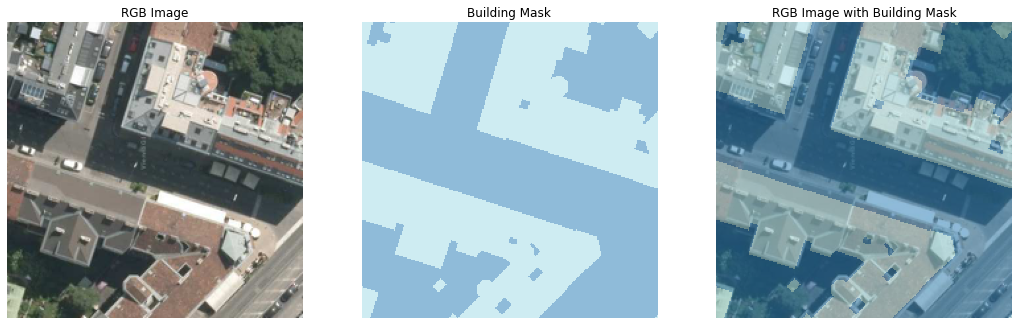

In [11]:
img_f = fnames[-1]
img = open_image(img_f)
mask = open_mask(get_y_fn(img_f), div=True)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,6))

ax1.set_title('RGB Image')
img.show(ax=ax1)

ax2.set_title('Building Mask')
mask.show(ax=ax2)

ax3.set_title('RGB Image with Building Mask')
img.show(ax=ax3)
mask.show(ax=ax3)

> Here, the dataset used is made by combining satellite/aerial images and their corresponding mask images. Here, an RGB Image, the ground truth building mask and the mask overlaid on the RGB image is shown to describe the data.

In [12]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[224 224]


tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 1],
         [1, 1, 1,  ..., 0, 1, 1]]])

> Here we can see that the mask is essentially a binary array comprising only of 0s and 1s, with 0 indicating that the pixel is not a building and 1 indicating that the pixel is a building. In this notebook, we are doing pixel-level analysis, so any pixel having more than 50% building coverage is labelled as 1 otherwise 0.

## 3. Making DataBunch

We will read all 8716 images and their corresponding masks into a single *DataBunch*. This is an object which we can initialize with parameters for train, test, split ratio and ```__init__``` datatype. The *DataBunch* will be useful in accessing the data throughout the experiment in an efficient way.

### 3.1 Define Patch Size and Batch Size

In [13]:
size = 224
bs = 6

> Here, since we are building upon UNet, which uses a ResNet34/50 encoder with input tensor of size ```(244,244)```, we will set the patch size as 224. We will set the batch size as 6. This can later be changed depending on the availability of more memory. 

In [14]:
# class encoding
codes = np.array(['Empty','Building'])

### 3.2 Set Databunch Initialization Parameters

In [15]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this? Currently no support
#available for PyTorch 1.5.0; can try updating to PyTorch 1.6.0
# This idea is taken from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageImageList):
    _label_cls = SegLabelListCustom

In [16]:
src = (SegItemListCustom.from_folder(path_img)
        .split_by_rand_pct(valid_pct=0.15)
        .label_from_func(get_y_fn, classes=codes))

> Here, we give refer the function```split_by_rand_pct()``` for creating a random split of the entire *DataBunch* at a random percentage each time this cell is run. To specify a seed percentage for splitting the data, please provide a keyword argument namely ```valid_pct``` indicating the percentage of validation data (ranges from 0 to 1). To use the entire *DataBunch* for training, use the function ```split_none()```.

### 3.3 Create DataBunch

In [17]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

> **NOTE:** While creating the databunch, if running on windows, we need to set the ```num_workers = 0``` while creating a databunch. What this does is, while multiprocessing, the python kernel will not create any extra threads. This is because of certain administrative restrictions on Windows which prevents multi-threading and often results into a ```BrokenPipe Error```

### 3.4 Describing DataBunch

In [18]:
data

ImageDataBunch;

Train: LabelList (7409 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ..\Pretrained\Dyanamic UNet\data\images;

Valid: LabelList (1307 items)
x: SegItemListCustom
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: SegLabelListCustom
ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224),ImageSegment (1, 224, 224)
Path: ..\Pretrained\Dyanamic UNet\data\images;

Test: None

> Here, we can observe that the *DataBunch* has been split into train and test with roughly 85:15 ratio. The network will be trained on 7409 tiles and will be validated on 1307 tiles.

In [19]:
data.valid_ds.items

array([WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_035_19_319430_270741_224_224_281_64_nw.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/23879050_15_224_224_1194_459_sw.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_051_19_319477_270826_224_224_48_153_nw.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_035_19_319436_270734_224_224_132_97_nw.png'), ...,
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_001_19_319373_270499_224_224_14_41_ne.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_022_19_319424_270670_224_224_287_52_se.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_022_19_319422_270661_224_224_172_230_se.png'),
       WindowsPath('../Pretrained/Dyanamic UNet/data/images/grid_043_corrected_19_319458_270793_224_224_8_271_nw.png')],
      dtype=object)

In [20]:
 data.train_ds.x[1], data.train_ds.y[1]

(Image (3, 224, 224), ImageSegment (1, 224, 224))

> Here we can observe that the images have been reshaped according to the patch size of ```(224,224)```. Moreover, the training image comprises of 3 channels (RGB) while the mask image, or label, comprises of a single channel only since it is a binary image having pixel values as either 1 or 0 (See Section 2.2 for more).

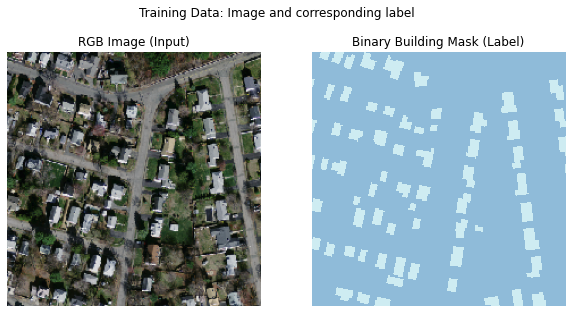

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Training Data: Image and corresponding label')
data.train_ds.x[1].show(ax=ax1)
ax1.set_title('RGB Image (Input)')

ax2.set_title('Binary Building Mask (Label)')
data.train_ds.y[1  ].show(ax=ax2)

In [22]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

#### 3.4.1 Describing Training Batch from *DataBunch*

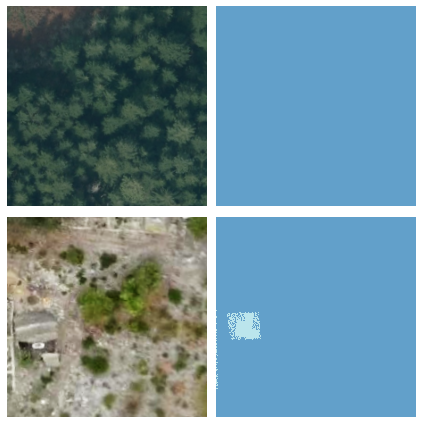

In [23]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

#### 3.4.2 Describing Validation Batch from *DataBunch*

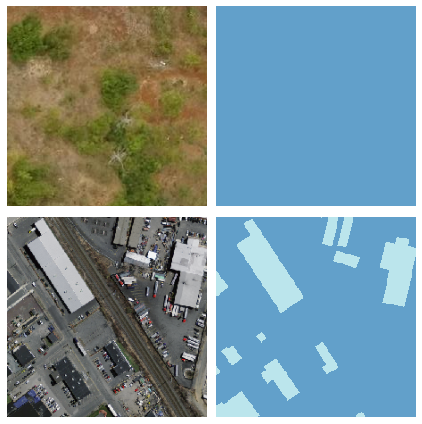

In [24]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

#### 3.4.3 Describing Classes

In [25]:
data.classes

array(['Empty', 'Building'], dtype='<U8')

## 4. Set Custom Loss as a Combination of Binary Cross Entropy Loss and Dice Loss

To train the model, we will use a custom loss which is a comnimation of:
* Dice Loss
The *Dice Loss* has been used to quantify the accuracy of the model in gauging the similarity of the predicted sample and the ground truth. It is similar to the *Intersection over Union (IoU)* metric, only it also accounts for crispness towards the edges/boundaries in the prediction.

* Binary Cross Entropy Loss
This is a loss based on the probability function. As the prediction probability diverges from the ground truth, this loss increases.

Here we have use a combination of these two losses to have composite model evaluation metrics, and also to be able to calculate the Macro-F1 score, which is obtained from the dice loss.

In [60]:
import pdb

In [27]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## 5. Define Model

### 5.1 Set Model Parameters

In [28]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

### 5.2 Set Model Metrics

In [29]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, accuracy_thresh, dice]

### 5.3 Initialize Learner with Dynamic UNet model available in FastAI

In [30]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

> Here, we are using UNet pretraind on ResNet34 model weights

In [31]:
learn.metrics = metrics

In [32]:
learn.metrics

[<function __main__.dice_loss(input, target)>,
 <function fastai.metrics.accuracy_thresh(y_pred:torch.Tensor, y_true:torch.Tensor, thresh:float=0.5, sigmoid:bool=True) -> <function NewType.<locals>.new_type at 0x00000242D742C8C8>>,
 <function fastai.metrics.dice(input:torch.Tensor, targs:torch.Tensor, iou:bool=False, eps:float=1e-08) -> <function NewType.<locals>.new_type at 0x00000242D742C8C8>>]

In [33]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [34]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

### 5.4 Find Learning Rate
This is a unique feature of FastAI - it simulates the training process for number of iterations equal to the first epoch and plots a graph of loss v/s learning rate. We can then choose the learning rate where the loss is minimum.

In [107]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


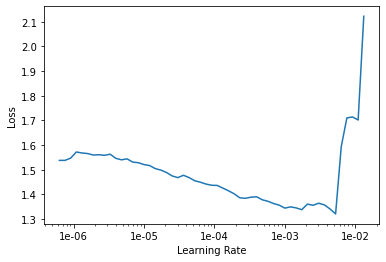

In [108]:
learn.recorder.plot()

> Based on the above graph, we can see that the loss troughs at ```lr = 1e-03```. So we will set that as the learning rate.

In [109]:
lr = 1e-03

### 5.5 Set up Custom Callbacks for best model while training
Here, we will override the ```SaveModelCallbackVerbose``` class to add the functionality of saving the model in an epoch if it is better than the one in the previous epoch, otherwise falling back to the one in the previous model.

In [110]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

## 6. Training

We use the ***Dynamic UNet***, which is an end-to-end *fully convolutional neural network* to learn the building extraction parameters. We use the *ResNet34* pretrained UNet for this study. Since it is a pretrained model, the weights of the nodes are already initialized based on the *ResNet34* training on the ImageNet dataset. Hence, we use the concept of **Transfer Learning** to train our model on the building images and their corresponding masks. A unique transfer training methodology is followed to achieve very high accuracy in very less time. This requires the training to be done in two steps:
1. Frozen Training (Training only the last few layers first)
2. Unforzen Training (Train the entire network with the last few layers already trained)

Along with this, we also integrate the **Cyclical Learning** concept which is greatly helpful in training models significantly quicker and with higher accuracy. In *Cyclical Learning*, the learning rate is not fixed during the entire training process, rather it will keep oscillating between a crest and a trough. Within Cyclical Learning, we use **SuperConvergence** and the *one cycle policy* to train our neural network an order of magnitude faster than with standard training methods. *Cylcical Learning* uses the Cyclical Learning Rate (CLR) method, which allows for the learning rate to constantly oscillate between a maxima and a minima. One CLR cycle consists of two steps: the part when the learning rate increases and the part where the learning rate decreases. Ideally a CLR method consists of many such cycles. Here, we further use the concept of *SuperConvergence* and *one cycle policy* which is essentially the the CLR method but only for one cycle. However, for the *one cycle policy*, the cycle size must be smaller than the total number of iterations. After the cycle is complete, the optimal learning rate range further decreases for the remaining iterations. Hence, in *SuperConvergence*, learning rate starts at a low value, then increases to a very large value and then decreases to a much lower value (even lower than its initial value).

This composite training methodology consisting of *Transfer Learning*, *Frozen-Unfrozen Training*, *Cyclical Learning* and *SuperConvergence* helps reduce the training time significantly and fetches a very high accuracy in very less number of epochs. 

### 6.1 Frozen Training

We use a Dynamic UNet pretrained on a ResNet34, so the model weights are already initialized. To transfer the learning for building extraction, we  first train the last few layers of the network, typically a *ceil* of 1/10th number of the total number of layers from the last. This sets the weights of the last few layers, which are otherwise the most difficult to train.

Here also, we implement the *SuperConvergence* and the *one cycle policy*. This implementation is provided in the fastAI library under the ```fit_one_cycle``` method.

We perform the frozen training for 10 epochs and then save model state.

In [111]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-512-best')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.491899,0.397397,0.225119,0.945738,0.633700,34:21
1,0.444688,0.341246,0.206772,0.947709,0.727341,27:06
2,0.377198,0.367407,0.225589,0.937694,0.713145,27:21
3,0.378871,0.328964,0.197202,0.952303,0.716275,27:21
4,0.334598,0.294221,0.176127,0.955641,0.745972,26:42
5,0.306127,0.292901,0.174997,0.954649,0.755155,26:08
6,0.302768,0.274539,0.166443,0.957331,0.759976,26:03
7,0.289113,0.265704,0.160332,0.959127,0.766676,25:49
8,0.258793,0.258914,0.155605,0.960915,0.772176,26:01
9,0.267871,0.256785,0.154790,0.960801,0.773344,25:53


Better model found at epoch 0 with dice value: 0.6337001323699951.
Better model found at epoch 1 with dice value: 0.7273414134979248.
Better model found at epoch 4 with dice value: 0.7459723353385925.
Better model found at epoch 5 with dice value: 0.7551546692848206.
Better model found at epoch 6 with dice value: 0.7599764466285706.
Better model found at epoch 7 with dice value: 0.7666758894920349.
Better model found at epoch 8 with dice value: 0.7721761465072632.
Better model found at epoch 9 with dice value: 0.7733443379402161.


> Here the accuracy right after the very first epoch is ~94% with a macro-F1 score of ~0.63. This is an evident advantage of our unique training method. Moreover, this is advantageous when we don't have a GPU or a high-end workstation to work with - ideally training to achieve such an accuracy would take upto 35-40 hours, but here we have the results within 6 hours, with roughly 35-40 minutes spent per epoch. Moreover, we have also implemented a *FallBack Provision*. What this does is, while training, if the model found at an epoch is not better than the one found at the previous epoch, it will immediately fall back to the one at the previous epoch. For eg: at epoch 3, a better model was not found than the one at epoch 2. So the saved model falls back to the one at epoch 2. Now, when the 4th epoch starts, weights from epoch 2 are modified and not epoch 3. 

> Hence, with these integrations, the training process has been made much faster and much more accurate within a short period of time and a small number of epochs. Currently, after *10 epochs* of *frozen training* and roughly *6 hours* of training time, the results are as follows:
>> * Accuracy: **96.08%**
>> * Macro-F1 score: **0.773**

In [113]:
learn.save('90-10_resnet_10-epochs_frozen')

> We save the model state after frozen training. This is good practice and is very helpful when we need to shut down our machine mid-training.

### 6.2 Unfrozen Training

We now *unfreeze* the model - what this essentially means is that now the trianing will impact all layers of the model and the weights of all the nodes will be modified. Since we have already trained the last few layers in the *frozen training* part, this process will be much quicker and will require a lower learning rate.

In [133]:
learn.unfreeze()

In [134]:
learn.lr_find()

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


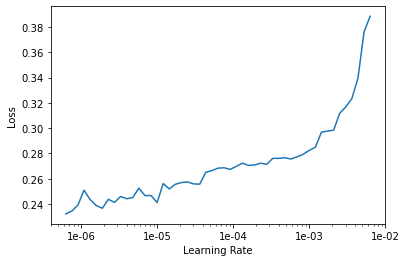

In [135]:
learn.recorder.plot()

> We observe that the learning rate has reduced drastically than what it was before: from 1e-03 to 1e-06, which conforms to the *SuperConvergence* policy. We set the learning rate accordingly.

In [136]:
lr = 1e-06

We again train the entire network for 10 epochs after *unfreezing* it with the same *one cycle policy* of *SuperConvergence*

In [137]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallback(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name='20190108-rn34unet-comboloss-alldata-512-best_unfrozen')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,accuracy_thresh,dice,time
0,0.262994,0.258716,0.155918,0.960397,0.772732,37:43
1,0.274927,0.257502,0.155456,0.960682,0.772231,25:56
2,0.261027,0.257925,0.155464,0.960646,0.774977,38:12
3,0.280205,0.254763,0.153545,0.961245,0.775033,39:17
4,0.272435,0.257291,0.154666,0.960945,0.774577,34:41
5,0.283086,0.255588,0.153950,0.960963,0.774268,36:22
6,0.262042,0.255193,0.153591,0.961218,0.774127,33:38
7,0.264681,0.256944,0.154562,0.960783,0.774247,35:58
8,0.257875,0.257309,0.154406,0.961150,0.774461,33:48
9,0.264914,0.256318,0.154357,0.961125,0.773910,25:58


Better model found at epoch 0 with dice value: 0.7727317214012146.
Better model found at epoch 2 with dice value: 0.7749770283699036.
Better model found at epoch 3 with dice value: 0.7750328183174133.


> Here, we observe an evident advantage of the *FallBack Provision*. During the *Unforzen Training*, the model kept improving until the 4th epoch, but not after that. Hence, even after the completion of 10 epochs, the model state was preserved to the epoch with best metrics.

> After the *Unfrozen Training* of 10 epochs, the final results are as follows:
>> * Accuracy: **96.124%**
>> * Macro-F1 score: **0.775**

In [138]:
learn.save('90-10_resnet_10-10-epochs_unfrozen')

### 6.3 Model Architecture - Describing the Dynamic UNet

In [35]:
learn.load('90-10_resnet_10-10-epochs_unfrozen')
learn.model.train()

DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05

### 6.4 Plotting Losses: Custom Loss (Section 4) per batches processed

#### 6.4.1 Losses After Frozen Training

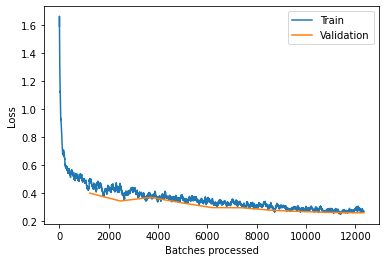

In [112]:
learn.recorder.plot_losses()

#### 6.4.2 Losses After Unfrozen Training

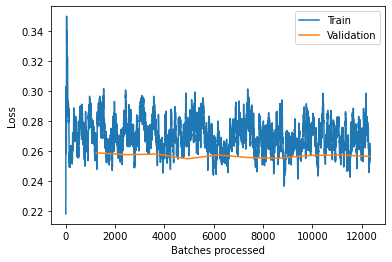

In [140]:
learn.recorder.plot_losses()

### 6.5 Exporting the Model for Deployment

We export the model so that we can use it in other environments and perform testing.

In [139]:
#ImageDataBunch.export('./export.pkl')
learn.export('90-10_resnet_10-10_unfrozen.pkl')

# 7. Evaluation

In [36]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [37]:
outputs.shape

torch.Size([6, 2, 224, 224])

> We predict a batch from validation data using the above trained model.

### 7.1 Thresholding the output to have a One-Hot Encoded Binary Feature Map

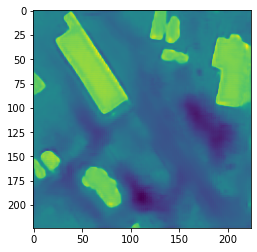

In [38]:
plt.imshow((outputs[1][1]).numpy())

The model predicts the probability for each pixel of being a building. Since we need a binary feature map, we will perform *Thresholding* using the *Sigmoid Function* for each pixel to have a binary feature map. The *Sigmoid Function* is defined as follows; where *'x'* is the pixel value:

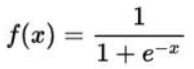

In [54]:
outputs[1].shape

torch.Size([2, 224, 224])

We apply the sigmoid function to define favourable pixels as only those having probability of being a building pixel greater than 95%. 

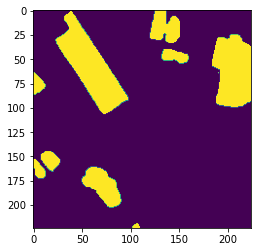

In [41]:
pred = to_np(outputs[1][1].sigmoid()>0.95)
plt.imshow(pred)

> Applying the *Sigmoid Function* gives us a One-Hot Encoded Binary Feature Map.

### 7.2 Evaluating Model on Validation Dataset

We evaluate the model on the 10% split of the entire dataset as validation dataset.
The metrics are based on True Postivies (TP), True Negatives (TN), False Positives (FP) and False Negatives (FN).
Since we have the *binary* feature maps of the predictions and the ground truth, we extract the TP, TN, FP and FN as follows:
* ```TP = Ground Truth & Prediction```           (Binary AND operator)
* ```TN = NOT(Ground Truth | Prediction)``` (Binary OR operator)
* ```FP = NOT(Ground Truth) & Prediction```  (Binary AND operator)
* ```FN = Ground Truth & NOT(Prediction)```  (Binary AND operator)

We use the following metrics to evaluate the model:
1. Accuracy
2. Precision OR Detection Percentage
3. Recall
4. Branching Factor
5. Miss Factor
6. Intersection over Union (IoU) OR Quality Percentage

In [57]:
from sklearn.metrics import jaccard_score as jsc

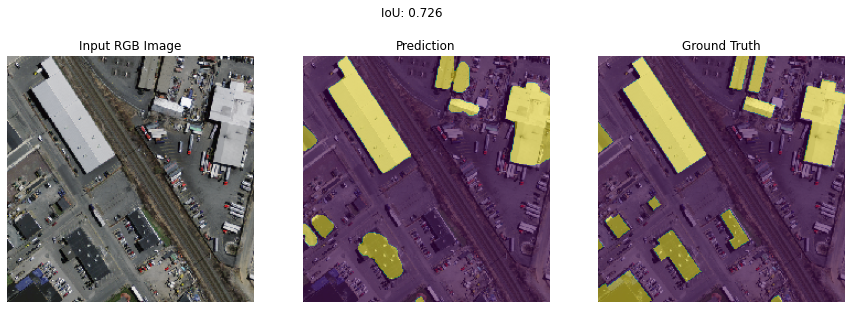

Accuracy:  0.945
Precision:  0.805
Recall:  0.88
Branching Factor:  0.136
Miss Factor:  0.242
Detection Percentage:  80.493
Quality Percentage:  72.558
                                               ************************                                               


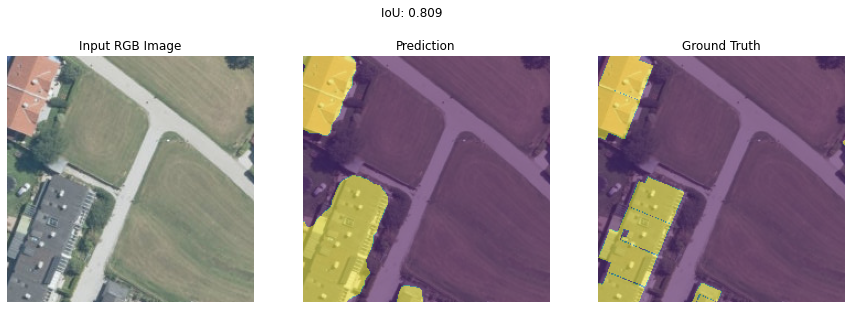

Accuracy:  0.964
Precision:  0.973
Recall:  0.827
Branching Factor:  0.209
Miss Factor:  0.027
Detection Percentage:  97.342
Quality Percentage:  80.857
                                               ************************                                               


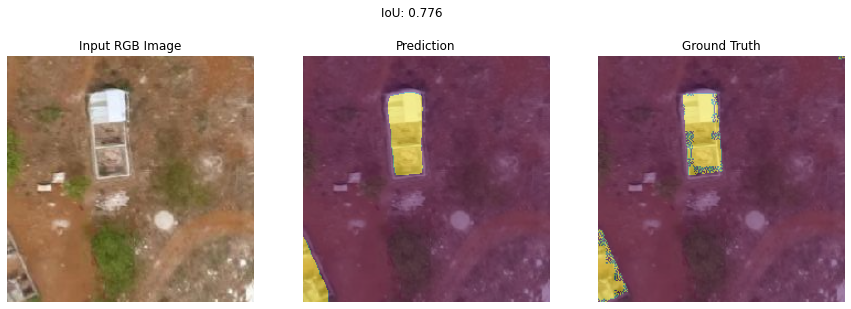

Accuracy:  0.986
Precision:  0.872
Recall:  0.876
Branching Factor:  0.142
Miss Factor:  0.147
Detection Percentage:  87.197
Quality Percentage:  77.61
                                               ************************                                               


In [58]:
#average metrics
accuracy_mean = []
precision_mean = []
recall_mean = []
branching_f_mean = []
miss_f_mean = []
detection_p_mean = []
iou_mean = []
quality_p_mean = []

for i in range(0,bs):
    # converting tensors to numpy arrays
    ground_truth = to_np(data.valid_ds.y[i])
    prediction = to_np(outputs[i][1].sigmoid()>0.95)
    
    # converting ground truth to binary/boolean arrays for calculating metrics
    gt = np.array(ground_truth[0], dtype=bool)
    # prediction is already a binary array
    
    if (not gt.sum()) or (not prediction.sum()):
        continue
    
    #getting TP, TN, FP, FN
    TP = (gt & prediction).sum()
    TN = np.invert(gt | prediction).sum()
    FP = (prediction & np.invert(gt)).sum()
    FN = (np.invert(prediction) & gt).sum()
    
    # calculating metrics
    iou = jsc(ground_truth[0].reshape(-1), prediction.reshape(-1))
    branching_factor = FP/TP
    miss_factor = FN/TP
    detection_percentage = 100*(TP/(TP+FN))
    quality_percentage = 100*(TP/(TP+FP+FN))
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FN)
    recall = TP/(TP+FP)
    
    accuracy_mean.append(accuracy)
    precision_mean.append(precision)
    recall_mean.append(recall)
    branching_f_mean.append(branching_factor)
    miss_f_mean.append(miss_factor)
    detection_p_mean.append(detection_percentage)
    quality_p_mean.append(quality_percentage)
    iou_mean.append(iou)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))
    
    fig.suptitle("IoU: " + str(round(iou, 3)))
    
    ax1.set_title('Input RGB Image')
    data.valid_ds.x[i].show(ax=ax1)
    
    ax2.set_title('Prediction')
    data.valid_ds.x[i].show(ax=ax2)
    ax2.imshow(prediction, alpha=0.5)
    
    ax3.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax3)
    ax3.imshow(ground_truth[0], alpha=0.5)
    plt.show()
    
    print("Accuracy: ", round(accuracy,3))
    print("Precision: ", round(precision,3))
    print("Recall: ", round(recall,3))
    print("Branching Factor: ", round(branching_factor,3))
    print("Miss Factor: ", round(miss_factor,3))
    print("Detection Percentage: ", round(detection_percentage,3))
    print("Quality Percentage: ", round(quality_percentage,3))
    print("************************".center(118))

In [59]:
sum(accuracy_mean)/len(accuracy_mean),sum(precision_mean)/len(accuracy_mean),sum(recall_mean)/len(accuracy_mean),sum(branching_f_mean)/len(miss_f_mean),sum(miss_f_mean)/len(accuracy_mean),sum(detection_p_mean)/len(accuracy_mean), sum(iou_mean)/len(iou_mean)

(0.9650297619047619,
 0.8834419590628766,
 0.8610425341905801,
 0.16232405141841283,
 0.13882390932422314,
 88.34419590628765,
 0.77008521717927)

#### Mean Evaluation Metrics

|     |      |
| -------------- | ----------- |
| **Accuracy** | 96.5 % |
| **Precision** |    88.34%     |
| **Recall** | 86.10% |
| **Branching Factor** | 16.23% |
| **Miss Factor** | 13.88% |
| **Detection Percentage** | 88.34% |
| ***mIoU*** | 0.77 |